### Dependencies

In [1]:
%pip install simpy
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install pandas
%pip install random2

Defaulting to user installation because normal site-packages is not writeable
  Using cached simpy-4.1.1-py3-none-any.whl.metadata (6.1 kB)
Using cached simpy-4.1.1-py3-none-any.whl (27 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is av

In [48]:
import simpy
import numpy as np
import random2 as random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
from collections import defaultdict
import pandas as pd

# Parameter Definitions

In [46]:
INITIAL_PEOPLE_ENTRANCE = 100
INITIAL_PEOPLE_METRO = 100
INITIAL_PEOPLE_CERCANIAS = 100

# Capacity limits
METRO_CAPACITY = 1000
CERCANIAS_CAPACITY = 750

# Operating hours
START_HOUR = 6.0    # 6:00 AM
END_HOUR = 25.5     # 1:30 AM (next day)

# Time distribution parameters
PEAK_HOUR_1 = 7.0    # 7:00 AM - Morning peak
SKEW_PARAM_1 = 4   # Controls skewness, positive for right-skew
SCALE_PARAM_1 = 4.0   # Scale parameter (spread of distribution)

PEAK_HOUR_2 = 18.0    # 6:00 PM - Evening peak
SKEW_PARAM_2 = -0.9    # Controls skewness, negative for left-skew
SCALE_PARAM_2 = 3.0   # Scale parameter (spread of distribution)

# Flow probabilities between areas
# From Metro
METRO_TO_METRO_PROB = 0.45     # Stay in Metro
METRO_TO_CERCANIAS_PROB = 0.25  # Go to Cercanias
METRO_TO_ENTRANCE_PROB = 0.30   # Go to Entrance

# From Entrance
ENTRANCE_TO_ENTRANCE_PROB = 0.05   # Stay in Entrance
ENTRANCE_TO_METRO_PROB = 0.60     # Go to Metro
ENTRANCE_TO_CERCANIAS_PROB = 0.35 # Go to Cercanias

# From Cercanias
CERCANIAS_TO_CERCANIAS_PROB = 0.02    # Stay in Cercanias
CERCANIAS_TO_METRO_PROB = 0.588       # Go to Metro
CERCANIAS_TO_ENTRANCE_PROB = 0.392    # Go to Entrance

# Generation rates for each area (people per hour)
METRO_GENERATION_RATE = 40      # People generated directly in Metro
ENTRANCE_GENERATION_RATE = 30   # People generated directly in Entrance
CERCANIAS_GENERATION_RATE = 35  # People generated directly in Cercanias

# Departure rates (% of people who leave the system per hour)
METRO_DEPARTURE_RATE = 0.50       # 10% of Metro population leaves per hour
ENTRANCE_DEPARTURE_RATE = 0.50    # 15% of Entrance population leaves per hour  
CERCANIAS_DEPARTURE_RATE = 0.50   # 10% of Cercanias population leaves per hour

# Simulation time step (in minutes)
STEP_INTERVAL = 10  # Minutes between each flow calculation

# Visualization parameters
DISPLAY_INTERVAL = 60  # Minutes between status updates
PLOT_TARGET_HOURS = [6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 25.5]  # Hours to analyze in charts

Using the specified 'Time Distribution Parameters', lets visualize our distribution of 'busyness' at Sol Station and compare it with Google Map's.

In [ ]:
x = np.linspace(0, 1, 1000)

# Peak 1: morning around 7am
pdf1 = stats.skewnorm.pdf(x, a=SKEW_PARAM_1, loc=PEAK_HOUR_1/24, scale=SCALE_PARAM_1/24)

# Peak 2: evening around 6pm
pdf2 = stats.skewnorm.pdf(x, a=SKEW_PARAM_2, loc=PEAK_HOUR_2/24, scale=SCALE_PARAM_2/24)
pdf = 0.4 * pdf1 + 0.6 * pdf2

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x * 24, pdf, label=f'SkewNorm PDF (peak ~{PEAK_HOUR_1}h)')
plt.xlabel('Hour of Day')
plt.ylabel('Probability Density')
plt.title('Skewed Normal Distribution of Arrivals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

img = mpimg.imread('sol_station_dist.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Class Definitions

## Util Classes
Here we define the TimeOfDay and StationArea utility classes. These classes are used throughout the simulation, and help us with:
>- Initializing the simulation's parameters and distribution of 'busyness'
>- Defining util functions to help with calculating time of day and retrieving the time_factor (busyness factor)
>- Creating a base class for all three areas in Sol Station (Entrance, Metro and Cercanias). This allows us to easily define/redefine the metrics we want to collect and clear them as well.

In [50]:
class TimeOfDay:
    """Models time of day and provides factors to adjust flow rates"""
    def __init__(self, start_hour=START_HOUR, end_hour=END_HOUR, peak_hour_1=PEAK_HOUR_1, 
                 skew_param_1=SKEW_PARAM_1, scale_param_1=SCALE_PARAM_1, peak_hour_2=PEAK_HOUR_2, 
                 skew_param_2=SKEW_PARAM_2, scale_param_2=SCALE_PARAM_2):
        self.start_hour = start_hour
        self.end_hour = end_hour
        self.peak_hour_1 = peak_hour_1
        self.peak_hour_2 = peak_hour_2
        self.operating_hours = end_hour - start_hour
        self.skew_param_1 = skew_param_1
        self.scale_param_1 = scale_param_1
        self.skew_param_2 = skew_param_2
        self.scale_param_2 = scale_param_2
        
        # Cached distribution values
        self._cached_x = np.linspace(0, 1, 1000)
        pdf1 = stats.skewnorm.pdf(self._cached_x, a=self.skew_param_1, loc=self.peak_hour_1/24, scale=self.scale_param_1/24)
        pdf2 = stats.skewnorm.pdf(self._cached_x, a=self.skew_param_2, loc=self.peak_hour_2/24, scale=self.scale_param_2/24)
        pdf = 0.4 * pdf1 + 0.6 * pdf2

        self._cached_pdf = pdf / pdf.max()  # Normalize to max 1.0
    
    def get_time_factor(self, hour):
        """Get the busyness factor based on time of day"""
        if hour < self.start_hour or hour > self.end_hour:
            return 0.0
        
        # Find the closest value in the distribution
        normalized_hour = (hour - self.start_hour) / self.operating_hours
        idx = int(normalized_hour * 1000)
        idx = max(0, min(idx, 999))  # Ensure index is within bounds
        
        return self._cached_pdf[idx]
    
    def format_hour(self, hour):
        """Convert decimal hour to HH:MM format"""
        is_next_day = hour >= 24
        hour_adjusted = hour % 24
        
        hours = int(hour_adjusted)
        minutes = int((hour_adjusted - hours) * 60)
        
        if is_next_day:
            return f"{hours:02d}:{minutes:02d} (next day)"
        else:
            return f"{hours:02d}:{minutes:02d}"

class StationArea:
    """Base class for station areas (Entrance, Metro, Cercanias)"""
    def __init__(self, env, name, initial_people, capacity=float('inf'), generation_rate=0, departure_rate=0):
        self.env = env
        self.name = name
        self.resource = simpy.Container(env, init=initial_people, capacity=capacity)
        self.waiting_people = 0
        self.turned_away = 0
        self.queue_times = []
        
        # Flow rates
        self.generation_rate = generation_rate
        self.departure_rate = departure_rate
        
        # Step metrics
        self.step_input = 0
        self.step_output = 0
        self.step_generated = 0
        self.step_departed = 0
        
        # Overall metrics
        self.metrics = {
            'queue_length': [],
            'time': [],
            'occupancy': [],
            'turned_away_count': [],
            'entries': defaultdict(int),
            'exits': defaultdict(int),
            'rejected': defaultdict(int)
        }
    
    def log_metrics(self):
        """Record current metrics"""
        current_time = self.env.now / 60.0  # Convert minutes to hours
        self.metrics['queue_length'].append(self.waiting_people)
        self.metrics['time'].append(current_time)
        self.metrics['occupancy'].append(self.resource.level)
        self.metrics['turned_away_count'].append(self.turned_away)
        
    def reset_flow_metrics(self):
        """Reset flow metrics for the next time period"""
        self.turned_away = 0
        self.metrics['entries'] = defaultdict(int)
        self.metrics['exits'] = defaultdict(int)
        self.metrics['rejected'] = defaultdict(int)
    
    def reset_step_metrics(self):
        """Reset metrics for the current step"""
        self.step_input = 0
        self.step_output = 0
        self.step_generated = 0
        self.step_departed = 0

## Fundamental Classes

Here we define the three areas in Sol Station (Entrance, Metro and Cercanias) and initializing them with their corresponding parameters.

Also, we define the Person class. This is what allows us to track each individual and therefore collect the essential 'wait_time' metric for each area in Sol Station.

In [51]:
class Entrance(StationArea):
    """Entrance area of the station"""
    def __init__(self, env, initial_people=INITIAL_PEOPLE_ENTRANCE, 
                 generation_rate=ENTRANCE_GENERATION_RATE, 
                 departure_rate=ENTRANCE_DEPARTURE_RATE):
        super().__init__(env, "Entrance", initial_people, float('inf'), 
                        generation_rate, departure_rate)

class Metro(StationArea):
    """Metro area of the station"""
    def __init__(self, env, initial_people=INITIAL_PEOPLE_METRO, 
                capacity=METRO_CAPACITY, 
                generation_rate=METRO_GENERATION_RATE, 
                departure_rate=METRO_DEPARTURE_RATE):
        super().__init__(env, "Metro", initial_people, capacity, 
                        generation_rate, departure_rate)

class Cercanias(StationArea):
    """Cercanias area of the station"""
    def __init__(self, env, initial_people=INITIAL_PEOPLE_CERCANIAS, 
                capacity=CERCANIAS_CAPACITY, 
                generation_rate=CERCANIAS_GENERATION_RATE, 
                departure_rate=CERCANIAS_DEPARTURE_RATE):
        super().__init__(env, "Cercanias", initial_people, capacity, 
                        generation_rate, departure_rate)

class Person:
    """Represents a person moving through the station"""
    def __init__(self, env, id, source="Generated", destination=None):
        self.env = env
        self.id = id
        self.entry_time = env.now
        self.source = source
        self.destination = destination
        self.current_area = None
        self.wait_start = None
        
    def start_waiting(self):
        """Mark the start of waiting time"""
        self.wait_start = self.env.now
        
    def stop_waiting(self, area):
        """Record the waiting time for an area"""
        if self.wait_start is not None:
            wait_time = self.env.now - self.wait_start
            area.queue_times.append(wait_time)
            self.wait_start = None

## Simulation Definition

document...

In [52]:
class StationSimulation:
    """Main simulation class for the Sol Metro station"""
    def __init__(self, env, time_system=None):
        self.env = env
        self.time_system = time_system or TimeOfDay()
        
        # Create station areas
        self.entrance = Entrance(env)
        self.metro = Metro(env)
        self.cercanias = Cercanias(env)
        
        # Keep track of people and timing
        self.person_count = 0
        self.hourly_data = []
        
        # Start processes
        self.processes = [
            # Generate and route people
            env.process(self.generate_and_route_people(self.metro)),
            env.process(self.generate_and_route_people(self.entrance)),
            env.process(self.generate_and_route_people(self.cercanias)),
            
            # Process departures from system
            env.process(self.process_departures(self.metro)),
            env.process(self.process_departures(self.entrance)),
            env.process(self.process_departures(self.cercanias)),
            
            # Metrics collection
            env.process(self.collect_metrics()),
            env.process(self.display_status()),
            env.process(self.report_flows())
        ]
        
        # Lists for plotting
        self.time_history = []
        self.metro_history = []
        self.cercanias_history = []
        self.entrance_history = []
    
    def get_current_hour(self):
        """Get the current simulation hour"""
        return self.time_system.start_hour + (self.env.now / 60.0)
    
    def get_time_factor(self):
        """Get time-based activity factor for current hour"""
        current_hour = self.get_current_hour()
        return self.time_system.get_time_factor(current_hour)
    
    def get_destination(self, source_area):
        """Determine destination based on probabilities for the given source area"""
        r = random.random()
        
        if source_area.name == "Metro":
            if r < METRO_TO_METRO_PROB:
                return "Metro"
            elif r < METRO_TO_METRO_PROB + METRO_TO_CERCANIAS_PROB:
                return "Cercanias"
            else:
                return "Entrance"
        
        elif source_area.name == "Entrance":
            if r < ENTRANCE_TO_ENTRANCE_PROB:
                return "Entrance"
            elif r < ENTRANCE_TO_ENTRANCE_PROB + ENTRANCE_TO_METRO_PROB:
                return "Metro"
            else:
                return "Cercanias"
        
        elif source_area.name == "Cercanias":
            if r < CERCANIAS_TO_CERCANIAS_PROB:
                return "Cercanias"
            elif r < CERCANIAS_TO_CERCANIAS_PROB + CERCANIAS_TO_METRO_PROB:
                return "Metro"
            else:
                return "Entrance"
        
        return None
    
    def get_area_by_name(self, name):
        """Get area object by name"""
        if name == "Metro":
            return self.metro
        elif name == "Entrance":
            return self.entrance
        elif name == "Cercanias":
            return self.cercanias
        return None
    
    def transfer_person(self, source_area, destination_name):
        """Transfer a person from source area to destination area"""
        # Get destination area
        destination_area = self.get_area_by_name(destination_name)
        
        if destination_area is None or source_area.name == destination_area.name:
            return True  # No transfer needed or invalid destination
        
        # Check if there's space in the destination
        if destination_area.resource.level >= destination_area.resource.capacity:
            # Destination is full, person can't transfer
            source_area.turned_away += 1
            source_area.metrics['rejected'][destination_area.name] += 1
            # print(f"Person couldn't transfer from {source_area.name} to {destination_area.name} - destination full")
            return False
        
        # Remove from source
        yield source_area.resource.get(1)
        source_area.metrics['exits'][destination_area.name] += 1
        source_area.step_output += 1
        
        # Add to destination
        yield destination_area.resource.put(1)
        destination_area.metrics['entries'][source_area.name] += 1
        destination_area.step_input += 1
        
        # print(f"Person transferred from {source_area.name} to {destination_area.name}")
        return True
    
    def generate_and_route_people(self, area):
        """Generate people in an area and immediately route them to their destinations"""
        while True:
            current_hour = self.get_current_hour()
            
            # Reset step metrics
            area.reset_step_metrics()
            
            # Skip if outside operating hours
            if current_hour < self.time_system.start_hour or current_hour > self.time_system.end_hour:
                yield self.env.timeout(STEP_INTERVAL)
                continue
            
            # Calculate generation rate based on time of day
            time_factor = self.time_system.get_time_factor(current_hour)
            adjusted_rate = area.generation_rate * time_factor * 3.0
            adjusted_rate = max(adjusted_rate, area.generation_rate * 0.2)
            
            # Scale down for the step interval (rate is per hour)
            step_rate = adjusted_rate * (STEP_INTERVAL / 6)
            
            # Generate random number of people
            to_generate = random.randint(int(0.7 * step_rate), int(1.3 * step_rate))
            
            print(f"Generating {to_generate} people in {area.name}")
            
            # Create and route each person individually
            for _ in range(to_generate):
                # Create a new person
                self.person_count += 1
                destination = self.get_destination(area)
                person = Person(self.env, self.person_count, f"Generated in {area.name}", destination)
                
                # Record generation
                area.step_generated += 1
                
                # If destination is the same as current area, just add them directly
                if destination == area.name:
                    # Check if there's enough capacity
                    if area.resource.level < area.resource.capacity:
                        yield area.resource.put(1)
                        area.metrics['entries']["Generated"] += 1
                        # print(f"Person {self.person_count} stays in {area.name}")
                    else:
                        area.turned_away += 1
                        area.metrics['rejected']["Generated"] += 1
                        # print(f"Person {self.person_count} rejected from {area.name} - no capacity")
                else:
                    # Transfer to the destination area
                    dest_area = self.get_area_by_name(destination)
                    
                    # Check if there's enough capacity in destination
                    if dest_area.resource.level < dest_area.resource.capacity:
                        # Add to destination
                        yield dest_area.resource.put(1)
                        dest_area.metrics['entries'][area.name] += 1
                        dest_area.step_input += 1
                        
                        # Record the transfer
                        area.metrics['exits'][destination] += 1
                        area.step_output += 1
                        
                        # print(f"Person {self.person_count} directly routed from {area.name} to {destination}")
                    else:
                        # Destination full, person couldn't be routed
                        dest_area.turned_away += 1
                        dest_area.metrics['rejected'][area.name] += 1
                        # print(f"Person {self.person_count} rejected - {destination} is full")
            
            # Wait until next generation cycle
            yield self.env.timeout(STEP_INTERVAL)
    
    def process_departures(self, area):
        """Process departures from the system from each area"""
        while True:
            current_hour = self.get_current_hour()
            
            # Skip if outside operating hours
            if current_hour < self.time_system.start_hour or current_hour > self.time_system.end_hour:
                yield self.env.timeout(STEP_INTERVAL)
                continue
            
            # Calculate departure rate based on time of day and current population
            time_factor = self.time_system.get_time_factor(current_hour)
            
            # The departure rate is a percentage of current population
            base_departures = area.resource.level * area.departure_rate
            adjusted_rate = base_departures * time_factor * 1.5
            adjusted_rate = max(adjusted_rate, base_departures * 0.5)
            
            # Scale down for the step interval (rate is per hour)
            step_rate = adjusted_rate * (STEP_INTERVAL / 60.0)
            
            # Calculate number of departures (capped by current population)
            to_depart = min(random.randint(int(0.7 * step_rate), int(1.3 * step_rate) + 1), 
                          area.resource.level)
            
            if to_depart > 0:
                # Remove people from the area
                yield area.resource.get(to_depart)
                
                # Record metrics
                area.step_departed += to_depart
                area.metrics['exits']["Departed"] += to_depart
                
                print(f"{to_depart} people departed from {area.name}")
            
            # Wait until next departure cycle
            yield self.env.timeout(STEP_INTERVAL)
    
    def report_flows(self):
        """Report input, output and net flows after each step interval"""
        while True:
            # Wait until the next step interval
            yield self.env.timeout(STEP_INTERVAL)
            
            current_hour = self.get_current_hour()
            
            # Skip if outside operating hours
            if current_hour < self.time_system.start_hour or current_hour > self.time_system.end_hour:
                continue
                
            formatted_time = self.time_system.format_hour(current_hour)
            
            print(f"\n ========== Flow Report at {formatted_time} ========== \n")
            
            # Report for each area
            for area in [self.metro, self.entrance, self.cercanias]:
                total_input = area.step_input + area.step_generated
                total_output = area.step_output + area.step_departed
                net_flow = total_input - total_output
                
                print(f"{area.name} Flows:")
                print(f"  Input Flow: {total_input} (Internal transfers: {area.step_input}, Generated: {area.step_generated})")
                print(f"  Output Flow: {total_output} (Internal transfers: {area.step_output}, Departed: {area.step_departed})")
                print(f"  Net Flow: {net_flow}")
                print(f"  Current Population: {area.resource.level}")
                print("")
    
    def collect_metrics(self):
        """Collect metrics every hour"""
        while True:
            # Wait until the next hour
            yield self.env.timeout(60)  # 60 minutes
            
            current_hour = self.get_current_hour()
            
            # Skip if outside operating hours
            if current_hour < self.time_system.start_hour or current_hour > self.time_system.end_hour:
                continue
            
            # Log metrics for each area
            self.metro.log_metrics()
            self.entrance.log_metrics()
            self.cercanias.log_metrics()
            
            # Save population data for plotting
            self.time_history.append(current_hour)
            self.metro_history.append(self.metro.resource.level)
            self.entrance_history.append(self.entrance.resource.level)
            self.cercanias_history.append(self.cercanias.resource.level)
            
            # Save hourly flow data
            hourly_snapshot = {
                "hour": current_hour,
                "formatted_hour": self.time_system.format_hour(current_hour),
                "metro_entries": dict(self.metro.metrics['entries']),
                "entrance_entries": dict(self.entrance.metrics['entries']),
                "cercanias_entries": dict(self.cercanias.metrics['entries']),
                "metro_exits": dict(self.metro.metrics['exits']),
                "entrance_exits": dict(self.entrance.metrics['exits']),
                "cercanias_exits": dict(self.cercanias.metrics['exits']),
                "metro_rejected": dict(self.metro.metrics['rejected']),
                "cercanias_rejected": dict(self.cercanias.metrics['rejected']),
                "metro_queue": self.metro.waiting_people,
                "entrance_queue": self.entrance.waiting_people,
                "cercanias_queue": self.cercanias.waiting_people,
                "metro_wait_time": np.mean(self.metro.queue_times) if self.metro.queue_times else 0,
                "entrance_wait_time": np.mean(self.entrance.queue_times) if self.entrance.queue_times else 0,
                "cercanias_wait_time": np.mean(self.cercanias.queue_times) if self.cercanias.queue_times else 0,
            }
            self.hourly_data.append(hourly_snapshot)
            
            # Reset flow metrics for the next hour
            self.metro.reset_flow_metrics()
            self.entrance.reset_flow_metrics()
            self.cercanias.reset_flow_metrics()
    
    def display_status(self):
        """Display status at regular intervals"""
        while True:
            yield self.env.timeout(DISPLAY_INTERVAL)
            
            current_hour = self.get_current_hour()
            if current_hour < self.time_system.start_hour or current_hour > self.time_system.end_hour:
                continue
                
            formatted_time = self.time_system.format_hour(current_hour)
            
            print(f"\n ========== Simulation Time: {formatted_time} ========== \n")
            print(f"Metro: {self.metro.resource.level} people (capacity: {self.metro.resource.capacity})")
            print(f"Entrance: {self.entrance.resource.level} people")
            print(f"Cercanias: {self.cercanias.resource.level} people (capacity: {self.cercanias.resource.capacity})")
            print(f"Time factor: {self.get_time_factor():.2f}")
            print("===========================================")
    
    def plot_results(self):
        """Plot simulation results"""
        # Create figure for population over time
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Population over time
        ax.plot(self.time_history, self.metro_history, label="Metro", color='blue')
        ax.plot(self.time_history, self.cercanias_history, label="Cercanias", color='green')
        ax.plot(self.time_history, self.entrance_history, label="Entrance", color='orange')
        
        # Format x-axis with time labels
        time_ticks = np.linspace(0, len(self.time_history)-1, min(10, len(self.time_history)), dtype=int)
        if len(time_ticks) > 0:
            time_labels = [self.time_system.format_hour(self.time_history[i]) for i in time_ticks]
            ax.set_xticks([self.time_history[i] for i in time_ticks])
            ax.set_xticklabels(time_labels, rotation=45)
        
        ax.set_title("Population at Sol Station Over Time")
        ax.set_xlabel("Time of Day")
        ax.set_ylabel("Number of People")
        ax.legend()
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Create plot for waiting times if available
        # if any(len(area.queue_times) > 0 for area in [self.metro, self.entrance, self.cercanias]):
        #     self.plot_waiting_times()
        self.plot_waiting_times()

        
        # Create flow analysis charts
        self.plot_flow_charts()
    
    def plot_waiting_times(self):
        """Plot waiting time statistics"""
        # Create figure for waiting times
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Extract waiting time data
        areas = ["Metro", "Entrance", "Cercanias"]
        wait_data = []
        print(self.hourly_data)
        
        for i, data in enumerate(self.hourly_data):
            wait_data.append({
                'hour': data['hour'],
                'Metro': data['metro_wait_time'],
                'Entrance': data['entrance_wait_time'],
                'Cercanias': data['cercanias_wait_time']
            })
        
        df = pd.DataFrame(wait_data)
        
        # Plot waiting times
        for area in areas:
            ax.plot(df['hour'], df[area], label=area)
        
        # Format x-axis with time labels
        time_ticks = np.linspace(min(df['hour']), max(df['hour']), 10)
        ax.set_xticks(time_ticks)
        ax.set_xticklabels([self.time_system.format_hour(h) for h in time_ticks], rotation=45)
        
        ax.set_title("Average Waiting Times")
        ax.set_xlabel("Time of Day")
        ax.set_ylabel("Average Wait Time (minutes)")
        ax.legend()
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    def plot_flow_charts(self):
        """Plot flow analysis charts for specific hours"""
        # Extract flow data from target hours for comparison
        target_hours = PLOT_TARGET_HOURS
        selected_data = []
        
        for hour in target_hours:
            # Find the closest data point to the target hour
            closest_idx = None
            min_diff = float('inf')
            
            for i, data in enumerate(self.hourly_data):
                diff = abs(data["hour"] - hour)
                if diff < min_diff:
                    min_diff = diff
                    closest_idx = i
            
            if closest_idx is not None and min_diff < 1.0:  # Only use if within 1 hour
                selected_data.append(self.hourly_data[closest_idx])
        
        # Create bar charts for each selected hour
        for data in selected_data:
            self.create_entity_flow_chart(data)
    
    def create_entity_flow_chart(self, data):
        """Create flow chart for a specific hour"""
        formatted_hour = data["formatted_hour"]
        
        # Create figure with 3 subplots (one for each entity)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Setup colors for different sources/destinations
        colors = {
            'Generated': 'grey',
            'Departed': 'grey', 
            'Metro': 'blue', 
            'Entrance': 'orange', 
            'Cercanias': 'green',
            'Rejected': 'red'
        }
        
        # Plot for Metro
        self.plot_entity_flows(
            ax1, 
            "Metro", 
            data["metro_entries"], 
            data["metro_exits"], 
            data["metro_rejected"],
            colors
        )
        
        # Plot for Entrance
        self.plot_entity_flows(
            ax2, 
            "Entrance", 
            data["entrance_entries"], 
            data["entrance_exits"], 
            {},  # No capacity limits for entrance
            colors
        )
        
        # Plot for Cercanias
        self.plot_entity_flows(
            ax3, 
            "Cercanias", 
            data["cercanias_entries"], 
            data["cercanias_exits"], 
            data["cercanias_rejected"],
            colors
        )
        
        # Set title for the entire figure
        fig.suptitle(f"People Flow Analysis at {formatted_hour}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Make room for the title
        plt.show()
    
    def plot_entity_flows(self, ax, entity_name, entries, exits, rejected, colors):
        """Plot flow data for one entity"""
        # Bar width
        width = 0.35
        
        # Get the sources and destinations
        sources = list(entries.keys())
        destinations = list(exits.keys())
        
        # Get the values
        entry_values = [entries.get(src, 0) for src in sources]
        exit_values = [exits.get(dest, 0) for dest in destinations]
        
        # Setup x positions
        x_pos_entries = np.arange(len(sources))
        x_pos_exits = np.arange(len(destinations)) + len(sources) + 1  # Add space between groups
        
        # Plot inflows
        entry_bars = ax.bar(x_pos_entries, entry_values, width, label='Entries', color=[colors[src] for src in sources])
        
        # Plot outflows
        exit_bars = ax.bar(x_pos_exits, exit_values, width, label='Exits', color=[colors[dest] for dest in destinations])
        
        # If there are rejected entries, plot them
        if rejected:
            x_pos_rejected = np.arange(len(rejected)) + len(sources) + len(destinations) + 2
            rejected_values = [rejected.get(src, 0) for src in rejected.keys()]
            rejected_bars = ax.bar(x_pos_rejected, rejected_values, width, label='Rejected', color='red')
            
            # Add rejected labels
            ax.set_xticks(np.concatenate([x_pos_entries, x_pos_exits, x_pos_rejected]))
            ax.set_xticklabels(sources + destinations + [f"Rej: {src}" for src in rejected.keys()], rotation=45)
        else:
            # No rejected entries
            ax.set_xticks(np.concatenate([x_pos_entries, x_pos_exits]))
            ax.set_xticklabels(sources + destinations, rotation=45)
        
        # Add labels and title
        ax.set_ylabel('Number of People')
        ax.set_title(f'{entity_name} Flow')
        
        # Add value labels on top of each bar
        for bars in [entry_bars, exit_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                            f'{int(height)}', ha='center', va='bottom')
        
        # Add a legend
        ax.legend()

# Running the Simulation

Generating 17 people in Metro
Generating 9 people in Entrance
Generating 11 people in Cercanias
4 people departed from Metro
2 people departed from Entrance
5 people departed from Cercanias

 ========== Flow Report at 06:10 ========== 

Metro Flows:
  Input Flow: 27 (Internal transfers: 10, Generated: 17)
  Output Flow: 16 (Internal transfers: 12, Departed: 4)
  Net Flow: 11
  Current Population: 111

Entrance Flows:
  Input Flow: 21 (Internal transfers: 12, Generated: 9)
  Output Flow: 10 (Internal transfers: 8, Departed: 2)
  Net Flow: 11
  Current Population: 111

Cercanias Flows:
  Input Flow: 19 (Internal transfers: 8, Generated: 11)
  Output Flow: 15 (Internal transfers: 10, Departed: 5)
  Net Flow: 4
  Current Population: 104

Generating 13 people in Entrance
Generating 10 people in Cercanias
Generating 10 people in Metro
6 people departed from Metro
6 people departed from Entrance
6 people departed from Cercanias

 ========== Flow Report at 06:19 ========== 

Metro Flows:
  Inp

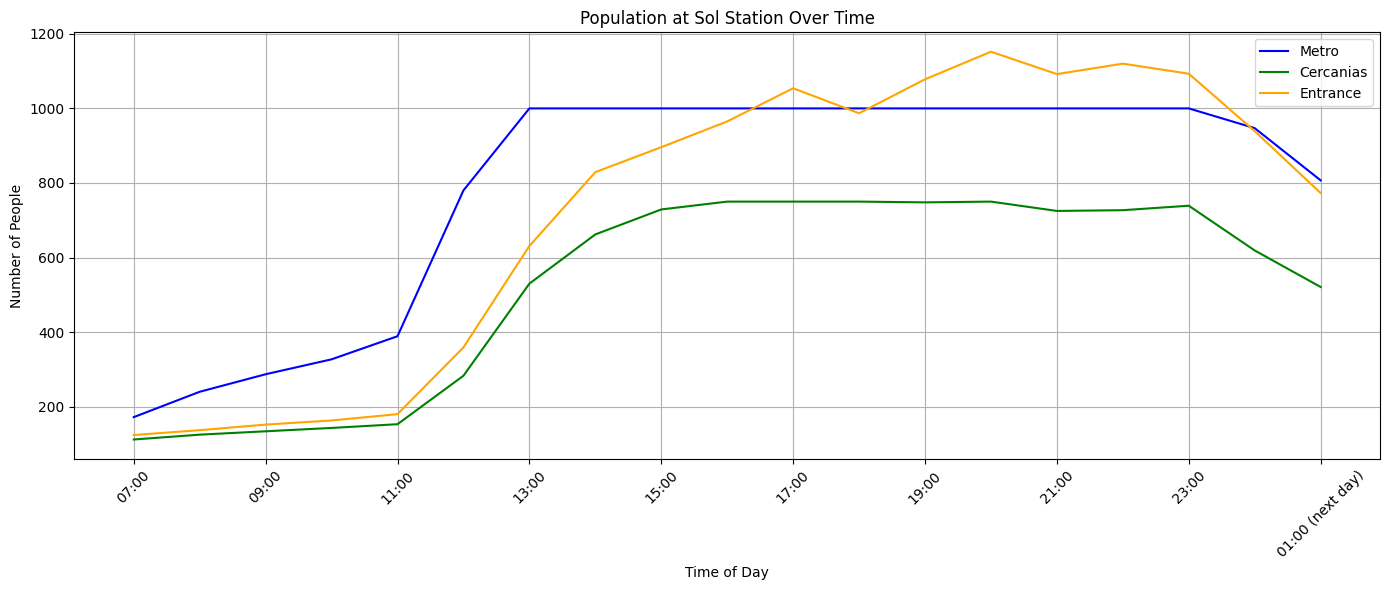

[{'hour': 7.0, 'formatted_hour': '07:00', 'metro_entries': {'Cercanias': 38, 'Entrance': 34, 'Generated': 33}, 'entrance_entries': {'Metro': 21, 'Cercanias': 29, 'Generated': 3}, 'cercanias_entries': {'Entrance': 26, 'Metro': 18, 'Generated': 1}, 'metro_exits': {'Entrance': 21, 'Departed': 33, 'Cercanias': 18}, 'entrance_exits': {'Cercanias': 26, 'Departed': 29, 'Metro': 34}, 'cercanias_exits': {'Entrance': 29, 'Departed': 33, 'Metro': 38}, 'metro_rejected': {}, 'cercanias_rejected': {}, 'metro_queue': 0, 'entrance_queue': 0, 'cercanias_queue': 0, 'metro_wait_time': 0, 'entrance_wait_time': 0, 'cercanias_wait_time': 0}, {'hour': 8.0, 'formatted_hour': '08:00', 'metro_entries': {'Entrance': 43, 'Generated': 29, 'Cercanias': 40}, 'entrance_entries': {'Cercanias': 21, 'Metro': 27, 'Generated': 1}, 'cercanias_entries': {'Metro': 23, 'Entrance': 21, 'Generated': 2}, 'metro_exits': {'Departed': 44, 'Entrance': 27, 'Cercanias': 23}, 'entrance_exits': {'Departed': 36, 'Metro': 43, 'Cercanias':

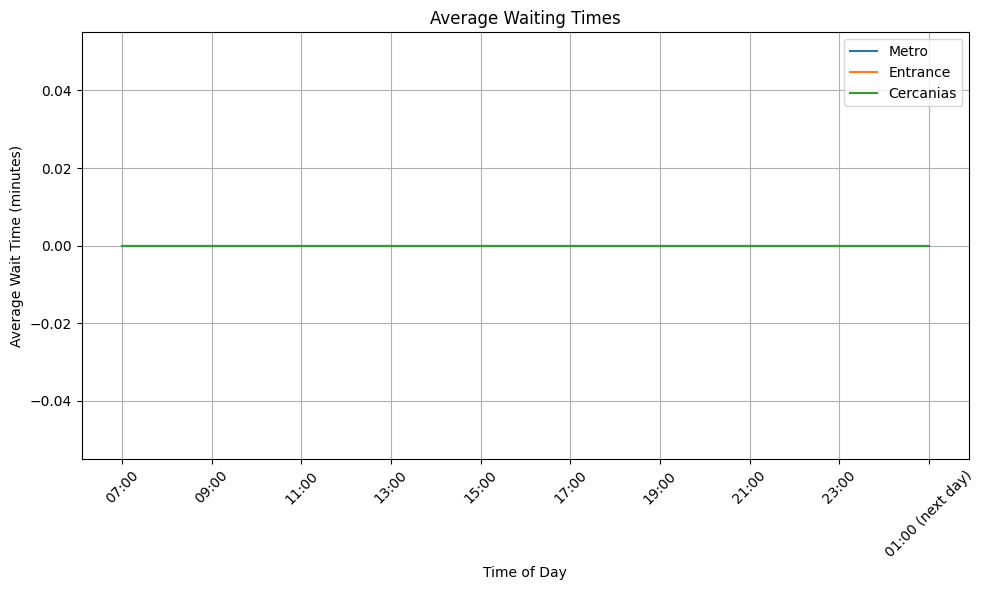

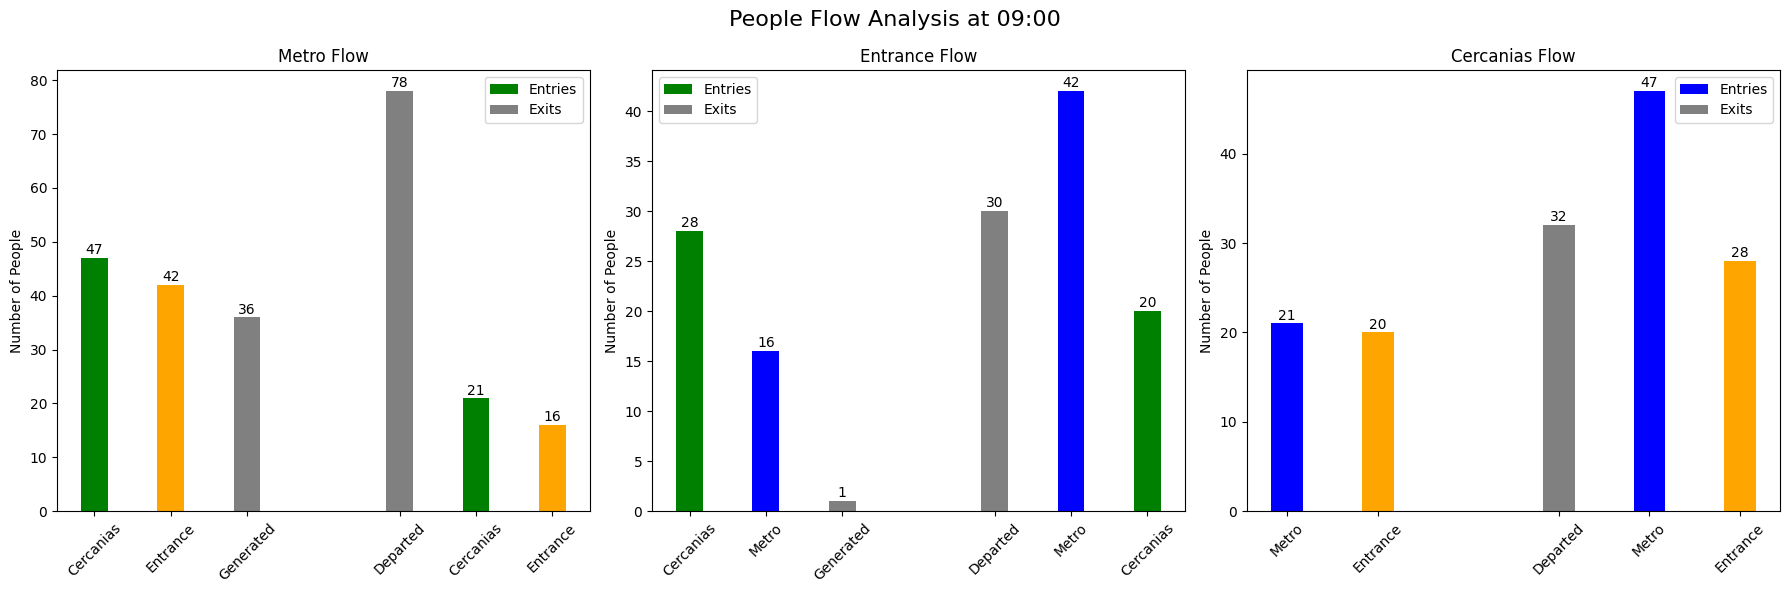

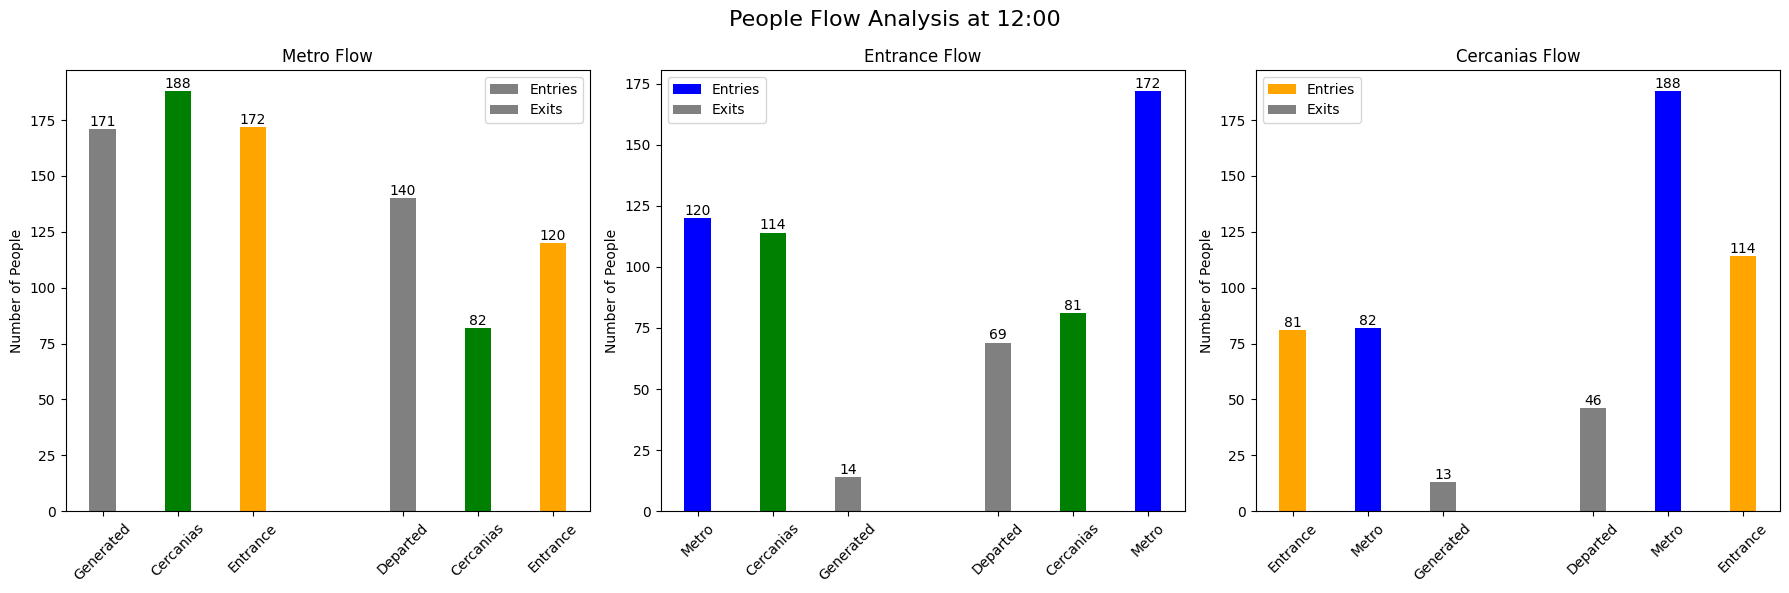

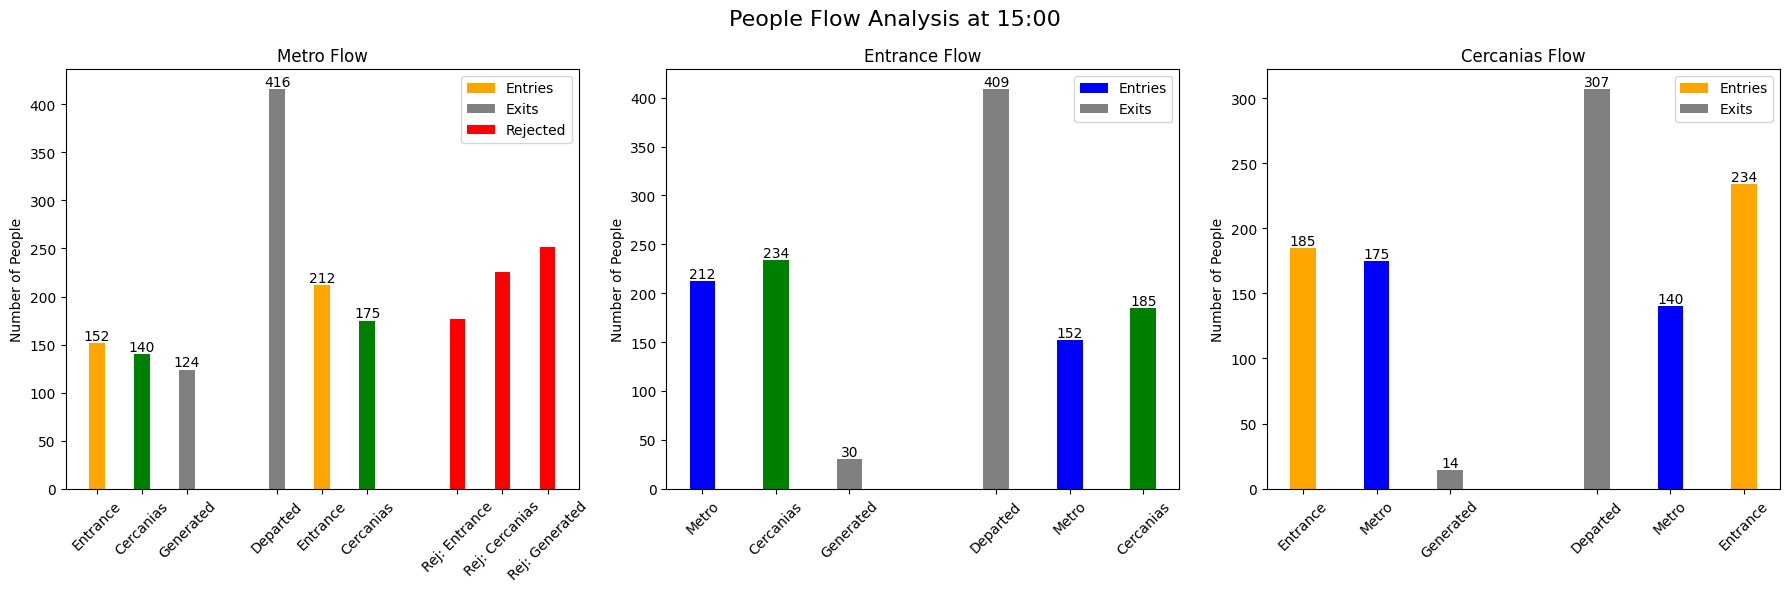

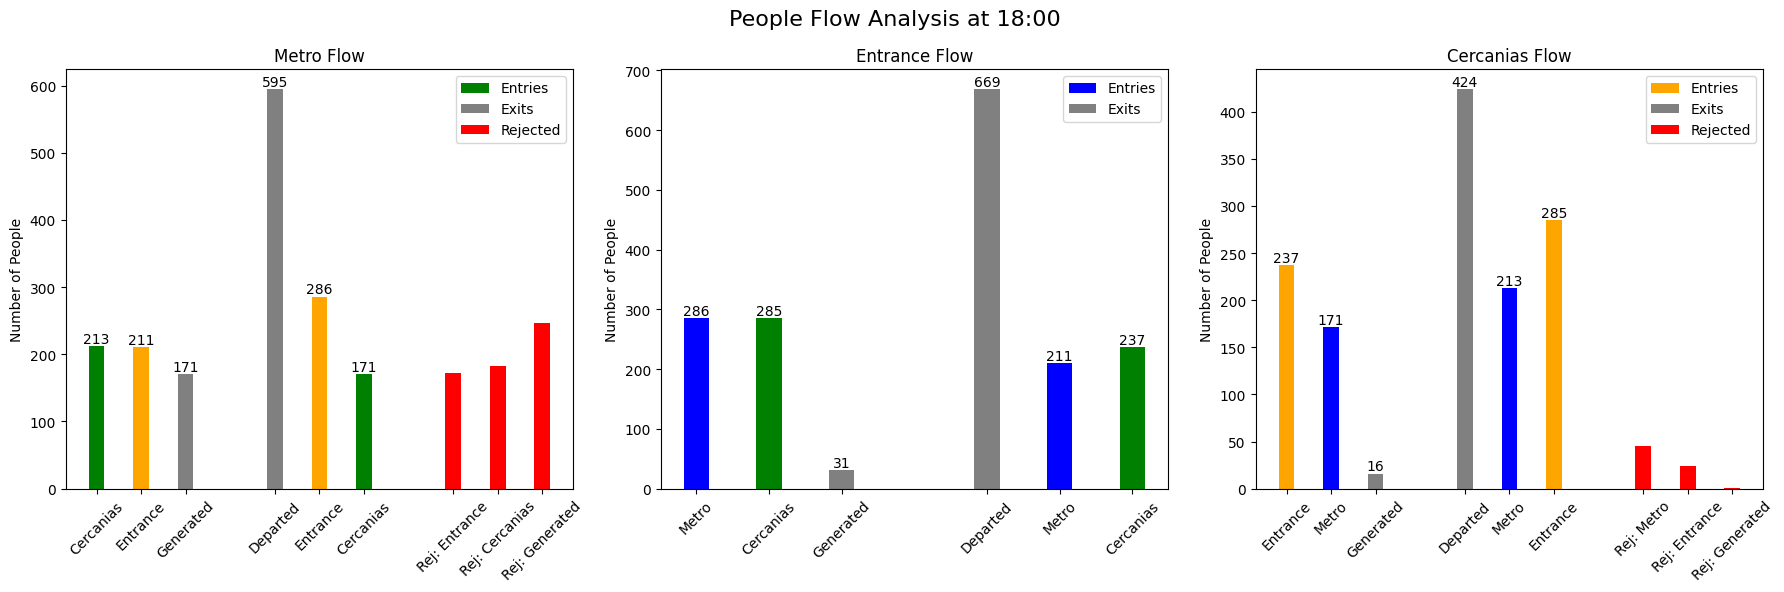

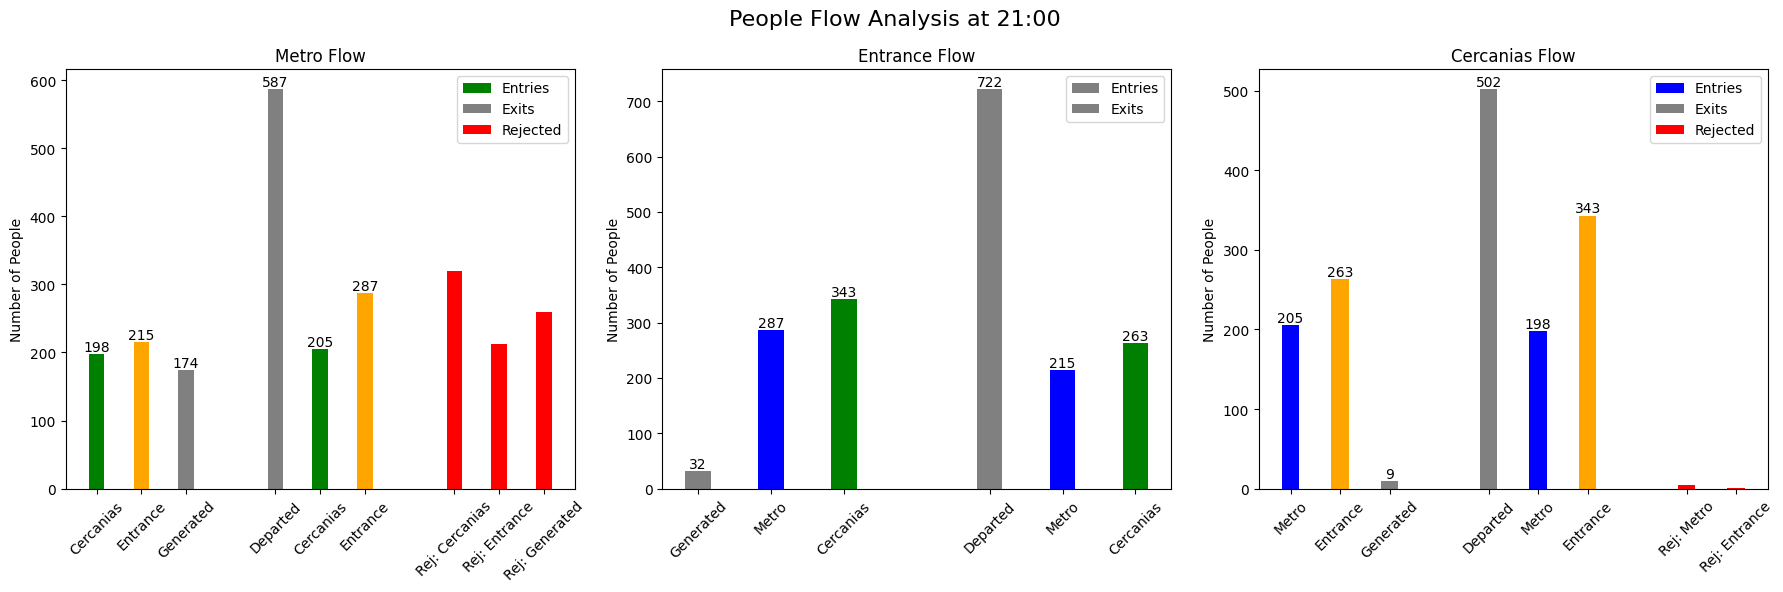

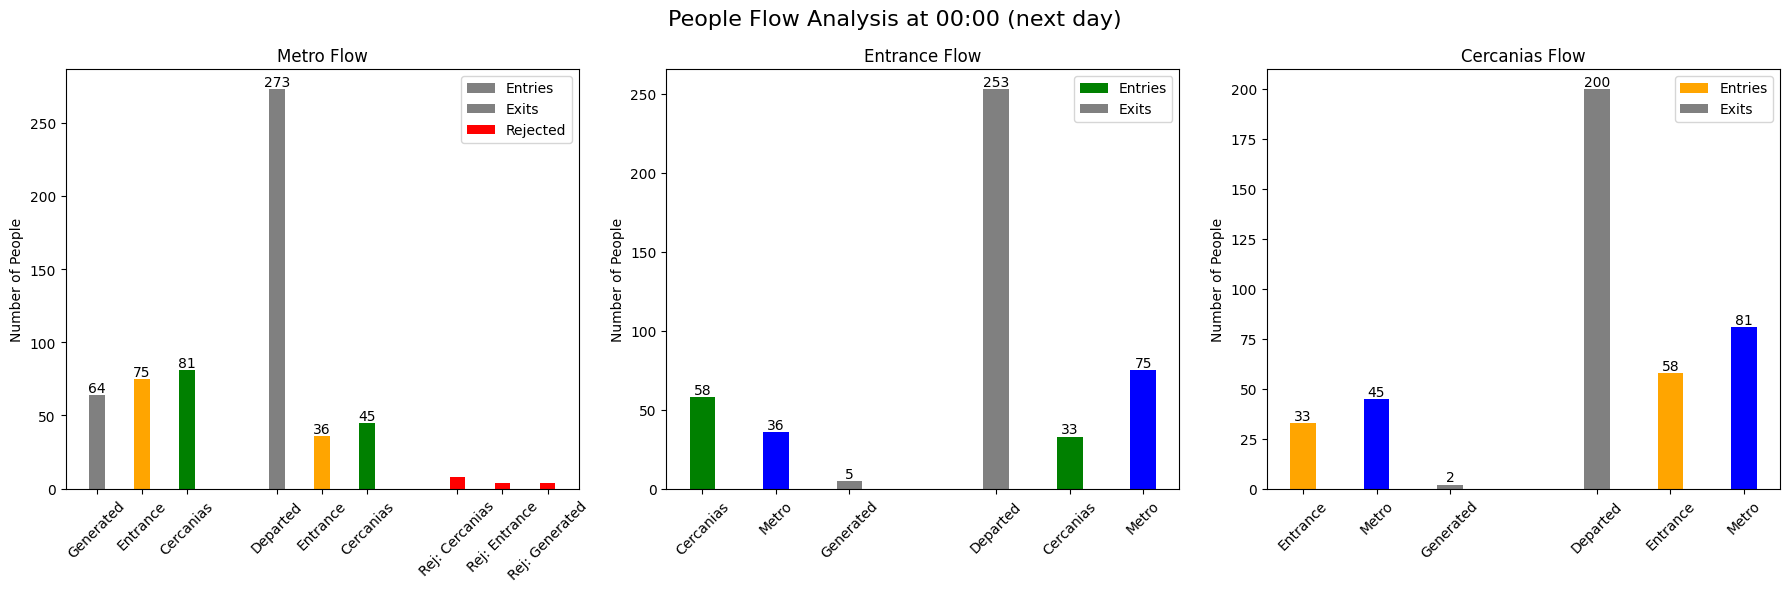

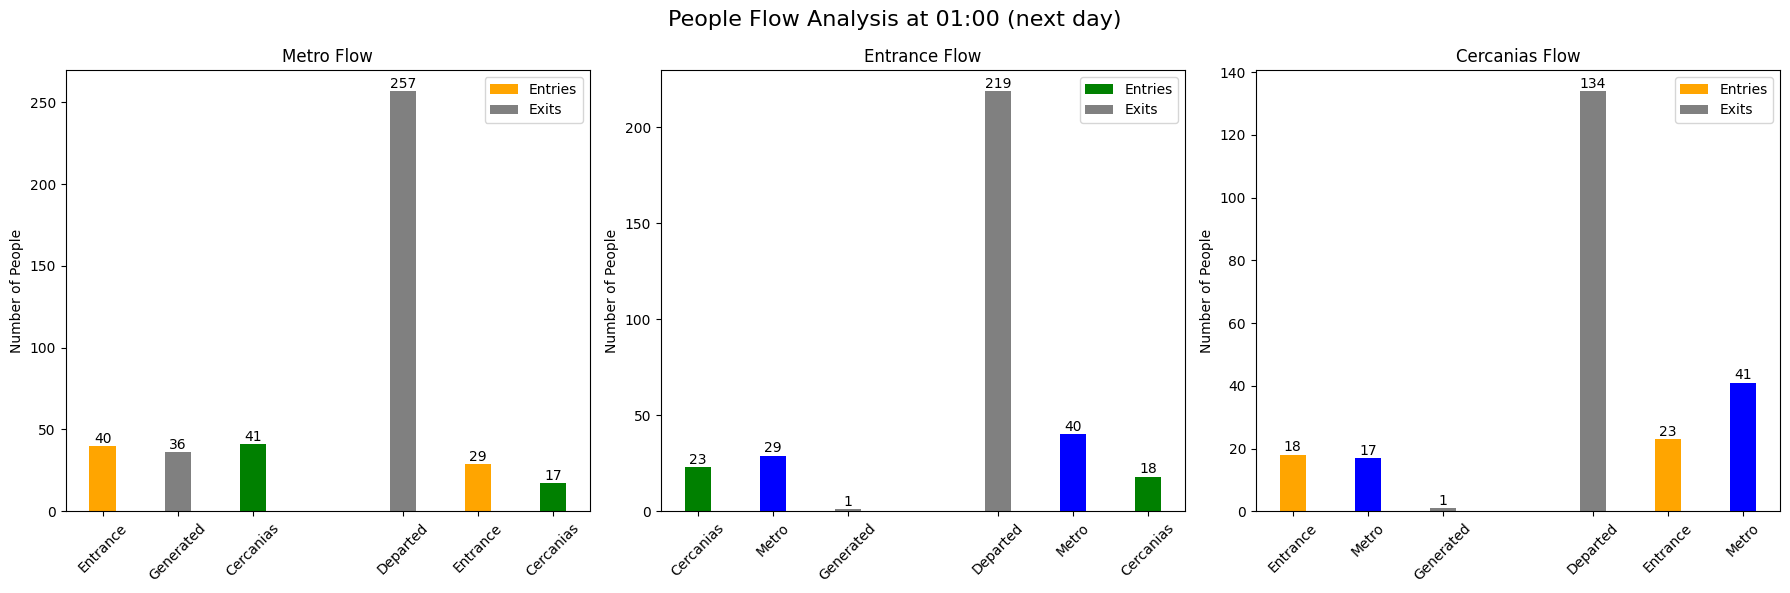

In [53]:
def run_simulation(sim_duration=24*60):
    """Run the simulation for the specified duration in minutes"""
    # Create SimPy environment
    env = simpy.Environment()
    
    # Create time system
    time_system = TimeOfDay()
    
    # Create and run simulation
    simulation = StationSimulation(env, time_system)
    
    # Run for specified duration (minutes)
    env.run(until=sim_duration)
    
    # Plot results
    simulation.plot_results()
    
    return simulation

run_simulation(1440)